# Data Quality Test

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy.stats import linregress
from multiprocessing import Pool

import snpy
from snpy.CSPtemp import st_template

%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "GFS Artemisia"
plt.rcParams['mathtext.fontset'] = "cm"

print(f'SNooPy version: v{snpy.__version__}')

SNOOPY_MODEL = 'max_model'
DATA_DIR = 'csp_data'
PROCESSES = 8

SNooPy version: v2.6.0


In [2]:
def bin_values(bins, x_values, y_values, y_err):
    """Values are binned using the given bins.
    
    Parameters
    ==========
    bins: array
        array of bins
    x_values: array
        array of x-axis values
    y_values: array
        array of y-axis values
    y_err: array
        array of y-axis errors
        
    Returns
    =======
    wmean_bins, std_bins: arrays
        Binned weighted mean and standard deviation.
    """
    
    digitized = np.digitize(x_values, bins)
    wmean_bins, std_bins = [], []
    
    for i in range(0, len(bins)):
        if len(y_values[digitized == i])>0:
            y = y_values[digitized == i]
            w = 1/y_err[digitized == i]**2
            
            # remove NaNs
            mask = ~np.isnan(y)
            y = y[mask]
            w = w[mask]
            if len(y)>0:
                wmean = np.average(y, weights=w)
                std = np.nanstd(y)
                wmean_bins.append(wmean)
                std_bins.append(std)
            else:
                wmean_bins.append(np.nan)
                std_bins.append(np.nan)
        else:
            wmean_bins.append(np.nan)
            std_bins.append(np.nan)

    wmean_bins = np.array(wmean_bins) 
    std_bins = np.array(std_bins)
    
    return wmean_bins, std_bins

def extract_gradient(st=1.0, bands=None):
    """Extracts the gradient from the SNooPy templates.
    
    Parameters
    ----------
    st: float
        SN stretch.
    bands: list-like, default `None`
        Bands to fit.
        
    returns
    -------
    lc_dict: dictionary
        Dictionary with the template light curves and 
        gradients.
    """
    
    t = st_template()
    t.st = st
    epochs = np.arange(-10, 80)
    if bands is None:
        bands = ['g', 'r', 'i', 'u', 'B', 'V', 
                 'J', 'H', 'Y']
    lc_dict = {band:None for band in bands}

    for band in bands:
        mag, mag_err, mask = t.eval(band, epochs, gen=2)
        lc_dict[band] = {'mag':mag[mask], 
                         'mag_err':mag_err[mask],
                         'time':epochs[mask]}
        gradient = []
        for i in range(len(epochs[mask])-1):
            # slope, intercept, r_value, p_value, std_err
            slope, _, _, _, _ = linregress(epochs[mask][i:i+2], 
                                           mag[mask][i:i+2])
            gradient.append(slope)
        lc_dict[band].update({'slope':np.array(gradient)})
        
    return lc_dict

def get_parameter(sn, parameter, include_sys=False):
    """Obtains the value of the given parameter and
    the total (systematics + statistical) uncertainty
    of a fitted SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    parameter: str
        Parameter to extract.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.
        
    Returns
    =======
    value: float
        Value of the parameter.
    err: float
        Total uncertainty in the parameter. 
    """
    
    value = sn.parameters[parameter]
    stats_err = sn.errors[parameter]
    if include_sys:
        sys_err = sn.systematics()[parameter]
    else:
        sys_err = 0.0
    err = np.sqrt(stats_err**2 + sys_err**2)
    
    return value, err

In [3]:
def running_cadence_mask(step, phases):
    """Extracts a mask of the given phases
    with True every `step` amount of items. The 'running'
    part means that the first observations moves along
    the time axes.
    
    Parameters
    ----------
    step: int
        Step to use to take every x amount of items.
    phases: list-like
        Phases.
        
    Returns
    -------
    running_masks: bool list
        List of masks.
    """
    length = len(phases)
    indeces = list(range(length))
    
    running_masks = []
    for i, phase in enumerate(phases):
        mask = []
        step_indeces = indeces[i::step]

        for index in indeces:
            if index in step_indeces:
                mask.append(True)
            else:
                mask.append(False)
        mask = np.array(mask)       
        running_masks.append(mask)
        if phase > 0 or len(step_indeces)<=3:
            break
    return running_masks

def update_running_cadence(sn_file, steps, bands=None):
    """Updates the light-curves cadence with the 
    given steps and fits the SN.
    
    Parameters
    ----------
    sn_file: SNooPy file
        SNooPy file for a given SN.
    steps: list-like
        Steps to use to take every x amount of items.
    bands: list, default `None`
        Bands to use for the SNooPy fits. If `None`,
        use all bands.
        
    Returns
    -------
    cadence_df: DataFrame
        Pandas dataframe with cadences and other 
        SN parameters.
    """
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)
    if bands is None:
        bands = sn.allbands()
        
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    # initial fit
    sn_copy = deepcopy(sn)
    sn_copy.fit(bands)
    
    cadences_list = []
    cadences = {band:None for band in sn_copy.allbands()}
    for band in sn_copy.allbands():
        lc_times = sn_copy.data[band].MJD
        cadences[band] = np.mean(np.diff(lc_times))
        
    Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn_copy, 'st', 
                                include_sys=False)
    first_phase = sn_copy.data[bands[0]].get_t()[0]/(1+sn_copy.z)
    
    cadences.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err, 
                     'first_phase':first_phase, 
                    'name':sn_copy.name, 'step':0})
    cadences_list.append(cadences)

    phases_dict = {band:sn_copy.data[band].get_t()/(1+sn_copy.z) 
                                               for band in bands}
    # fits for multiple cadences
    for step in steps:
        mask_dict = {band:None for band in bands}
        for band in bands:
            phases = phases_dict[band]
            running_masks = running_cadence_mask(step, phases)
            mask_dict[band] = running_masks
           
        # check max length
        max_len = 50
        for mask_list in mask_dict.values():
            if len(mask_list)<max_len:
                max_len = len(mask_list)
            
        # iterate over each running 1st observation
        for i in range(max_len):
            cadences = {band:None for band in bands}
            sn_copy = deepcopy(sn)
            
            for band in bands:
                mask = mask_dict[band][i]
                
                sn_copy.data[band].mag = sn_copy.data[band].mag[mask]
                sn_copy.data[band].magnitude = sn_copy.data[band].magnitude[mask]
                sn_copy.data[band].e_mag = sn_copy.data[band].e_mag[mask]
                sn_copy.data[band].MJD = sn_copy.data[band].MJD[mask]
                
                lc_times = sn_copy.data[band].MJD
                cadences[band] = np.mean(np.diff(lc_times))
                
                sn_copy.data[band].__dict__['mask'] = [True]*len(lc_times)
                sn_copy.data[band].sids = np.zeros_like(lc_times)
                
            try:
                sn_copy.fit(bands)

                Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                           include_sys=False)
                st, st_err = get_parameter(sn_copy, 'st', 
                                            include_sys=False)
                first_phase = sn_copy.data[bands[0]].get_t()[0]/(1+sn_copy.z)

                cadences.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                                 'st':st, 'st_err':st_err, 
                                 'first_phase':first_phase, 
                                'name':sn_copy.name, 'step':step})
                cadences_list.append(cadences)
            except Exception as message:
                print(f'Iteration numer {i} failed for {sn.name}: {message}!')
        
    # add NaN to bands with no information
    bands = ['g', 'r', 'i', 'u', 'B', 'V', 'J', 'H', 'Y']
    for cadence in cadences_list:
        for band in bands:
            if band not in cadence.keys():
                cadence.update({band:np.nan})
      
    cadence_df = pd.DataFrame(cadences_list)
    
    return cadence_df

def update_snr(sn_file, multi, bands=None):
    """Updates the light-curves S/N with the 
    given multiplicative values and fits the SN.
    
    Parameters
    ----------
    sn_file: SNooPy file
        SNooPy file for a given SN.
    multi: list-like
        Multiplicative values such that x*sigma is used
        as errors in the observations.
    bands: list, default `None`
        Bands to use for the SNooPy fits. If `None`,
        use all bands.
        
    Returns
    -------
    snr_df: DataFrame
        Pandas dataframe with snr and other 
        SN parameters.
    """
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)
    if bands is None:
        bands = sn.allbands()
        
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    # initial fit
    sn_copy = deepcopy(sn)
    sn_copy.fit(bands)
    
    snr_list = []
    snr_dict = {band:None for band in sn_copy.allbands()}
    for band in sn_copy.allbands():
        snr = sn_copy.data[band].flux/sn_copy.data[band].e_flux
        snr_dict[band] = np.mean(snr)
    Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn_copy, 'st', 
                                include_sys=False)
    snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err,
                    'name':sn_copy.name})
    snr_list.append(snr_dict)

    # iterate over S/N multipliers
    for mult in multi:
        # as the observations are resampled within the uncertainties, we can 
        # repeat this several times generating new simulations for the same multiplier 
        for _ in range(10):
            snr_dict = {band:None for band in bands}
            sn_copy = deepcopy(sn)
            for band in bands:   
                # update flux errors
                sn_copy.data[band].e_flux = mult*sn_copy.data[band].e_flux
                sn_copy.data[band]._eflux = mult*sn_copy.data[band]._eflux

                zp = sn_copy.data[band].mag + 2.5*np.log10(sn_copy.data[band].flux)
                # randomise observations within uncertainties
                new_flux = np.random.normal(sn_copy.data[band].flux, 
                                            sn_copy.data[band].e_flux)
                sn_copy.data[band].flux = new_flux

                # update magnitudes and mag errors
                new_mag = -2.5*np.log10(new_flux) + zp
                new_mag_err = np.abs( 2.5*sn_copy.data[band].e_flux/(new_flux*np.log(10)) )
                sn_copy.data[band].mag = new_mag
                sn_copy.data[band].magnitude = new_mag
                sn_copy.data[band].e_mag = new_mag_err

                snr = sn_copy.data[band].flux/sn_copy.data[band].e_flux
                # use median as S/N can vary a lot within a light curve
                snr_dict[band] = np.median(snr)

            try:
                sn_copy.fit(bands)
                Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                           include_sys=False)
                st, st_err = get_parameter(sn_copy, 'st', 
                                            include_sys=False)
                snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                                 'st':st, 'st_err':st_err, 
                                'name':sn_copy.name})
                snr_list.append(snr_dict)
            except Exception as message:
                    print(f'Multiplier {mult} failed for {sn.name}: {message}!')
        
    # add NaN to bands with no information
    bands = ['g', 'r', 'i', 'u', 'B', 'V', 'J', 'H', 'Y']
    for snr in snr_list:
        for band in bands:
            if band not in snr.keys():
                snr.update({band:np.nan})
      
    snr_df = pd.DataFrame(snr_list)
    
    return snr_df

In [4]:
def update_NIR_snr(sn_file, multi, bands=None):
    """Updates the NIR light-curves S/N with the 
    given multiplicative values and fits the SN.
    
    Parameters
    ----------
    sn_file: SNooPy file
        SNooPy file for a given SN.
    multi: list-like
        Multiplicative values such that x*sigma is used
        as errors in the observations.
    bands: list, default `None`
        Bands to use for the SNooPy fits. If `None`,
        use all bands.
        
    Returns
    -------
    snr_df: DataFrame
        Pandas dataframe with NIR snr and other 
        SN parameters.
    """
    sn = snpy.import_lc(sn_file)
    sn.choose_model(SNOOPY_MODEL)
    if bands is None:
        bands = ['g', 'r', 'J', 'H']
        
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    # initial fit
    sn_copy0 = deepcopy(sn)
    sn_copy0.fit(bands)
    
    snr_list = []
    snr_dict = {band:None for band in bands}
    for band in bands:
        snr = sn_copy0.data[band].flux/sn_copy0.data[band].e_flux
        snr_dict[band] = np.mean(snr)
    Tmax, Tmax_err = get_parameter(sn_copy0, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn_copy0, 'st', 
                                include_sys=False)
    Jmax, Jmax_err = get_parameter(sn_copy0, 'Jmax', 
                                    include_sys=False)
    Hmax, Hmax_err = get_parameter(sn_copy0, 'Hmax', 
                                    include_sys=False)
    snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err,
                     'Jmax':Jmax, 'Jmax_err':Jmax_err,
                     'Hmax':Hmax, 'Hmax_err':Hmax_err,
                    'name':sn_copy0.name})
    snr_list.append(snr_dict)
    
    # 2nd fit
    sn_copy = deepcopy(sn)
    for band in ['J', 'H']:
        mult = 1
        # mask for single epoch closest to Tmax
        ind = np.argmin(np.abs(sn_copy.data[band].MJD-sn_copy0.Tmax))
        mask = sn_copy.data[band].MJD[ind]==sn_copy.data[band].MJD

        sn_copy.data[band].e_flux = mult*sn_copy.data[band].e_flux[mask]
        sn_copy.data[band]._eflux = mult*sn_copy.data[band]._eflux[mask]

        zp = sn_copy.data[band].mag[mask] + 2.5*np.log10(sn_copy.data[band].flux[mask])
        # randomise observations within uncertainties
        new_flux = np.random.normal(sn_copy.data[band].flux[mask], 
                                    sn_copy.data[band].e_flux)
        sn_copy.data[band].flux = new_flux

        # update magnitudes and mag errors
        new_mag = -2.5*np.log10(new_flux) + zp
        new_mag_err = np.abs( 2.5*sn_copy.data[band].e_flux/(new_flux*np.log(10)) )
        sn_copy.data[band].mag = new_mag
        sn_copy.data[band].magnitude = new_mag
        sn_copy.data[band].e_mag = new_mag_err

        sn_copy.data[band].MJD = sn_copy.data[band].MJD[mask]
        sn_copy.data[band].__dict__['mask'] = [True]
        sn_copy.data[band].sids = [0]

    sn_copy.fit(bands)
    
    snr_dict = {band:None for band in bands}
    for band in bands:
        snr = sn_copy.data[band].flux/sn_copy.data[band].e_flux
        snr_dict[band] = np.mean(snr)
    Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn_copy, 'st', 
                                include_sys=False)
    Jmax, Jmax_err = get_parameter(sn_copy, 'Jmax', 
                                    include_sys=False)
    Hmax, Hmax_err = get_parameter(sn_copy, 'Hmax', 
                                    include_sys=False)
    snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err,
                     'Jmax':Jmax, 'Jmax_err':Jmax_err,
                     'Hmax':Hmax, 'Hmax_err':Hmax_err,
                    'name':sn_copy.name})
    snr_list.append(snr_dict)

    # iterate over S/N multipliers
    for mult in multi:
        # as the observation is resampled within the uncertainty, we can repeat
        # this several times generating new simulations for the same multiplier 
        for _ in range(10):
            snr_dict = {band:None for band in bands}
            sn_copy = deepcopy(sn)
            for band in ['J', 'H']:   
                # mask for single epoch closest to Tmax
                ind = np.argmin(np.abs(sn_copy.data[band].MJD-sn_copy0.Tmax))
                mask = sn_copy.data[band].MJD[ind]==sn_copy.data[band].MJD

                sn_copy.data[band].e_flux = mult*sn_copy.data[band].e_flux[mask]
                sn_copy.data[band]._eflux = mult*sn_copy.data[band]._eflux[mask]

                zp = sn_copy.data[band].mag[mask] + 2.5*np.log10(sn_copy.data[band].flux[mask])
                # randomise observations within uncertainties
                new_flux = np.random.normal(sn_copy.data[band].flux[mask], 
                                            sn_copy.data[band].e_flux)
                sn_copy.data[band].flux = new_flux

                # update magnitudes and mag errors
                new_mag = -2.5*np.log10(new_flux) + zp
                new_mag_err = np.abs( 2.5*sn_copy.data[band].e_flux/(new_flux*np.log(10)) )
                sn_copy.data[band].mag = new_mag
                sn_copy.data[band].magnitude = new_mag
                sn_copy.data[band].e_mag = new_mag_err

                sn_copy.data[band].MJD = sn_copy.data[band].MJD[mask]
                sn_copy.data[band].__dict__['mask'] = [True]
                sn_copy.data[band].sids = [0]

            try:
                sn_copy.fit(bands)
                snr_dict = {band:None for band in bands}
                for band in bands:
                    snr = sn_copy.data[band].flux/sn_copy.data[band].e_flux
                    snr_dict[band] = np.mean(snr)
                Tmax, Tmax_err = get_parameter(sn_copy, 'Tmax', 
                                           include_sys=False)
                st, st_err = get_parameter(sn_copy, 'st', 
                                            include_sys=False)
                Jmax, Jmax_err = get_parameter(sn_copy, 'Jmax', 
                                            include_sys=False)
                Hmax, Hmax_err = get_parameter(sn_copy, 'Hmax', 
                                            include_sys=False)
                snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                                 'st':st, 'st_err':st_err, 
                                 'Jmax':Jmax, 'Jmax_err':Jmax_err,
                                 'Hmax':Hmax, 'Hmax_err':Hmax_err,
                                'name':sn_copy.name})
                snr_list.append(snr_dict)
            except Exception as message:
                    print(f'Multiplier {mult} failed for {sn.name}: {message}!')
        
    # add NaN to bands with no information
    bands = ['g', 'r', 'i', 'u', 'B', 'V', 'J', 'H', 'Y']
    for snr in snr_list:
        for band in bands:
            if band not in snr.keys():
                snr.update({band:np.nan})
      
    snr_df = pd.DataFrame(snr_list)
    
    return snr_df

In [5]:
def pool_fit_cad(inputs):
    '''Fits a SN with SNooPy using multiple cadences and 
    returns the saved results.
    
    Parameters
    ==========
    inputs: list
        Same as in `update_running_cadence()`.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''        
    try:
        sn_file, steps, bands = inputs
        cadence_df = update_running_cadence(sn_file, steps, bands)
        return cadence_df
    except Exception as message:
        print(f'Unable to fit {sn_file}: {message}')
        
def pool_fit_snr(inputs):
    '''Fits a SN with SNooPy using multiple S/N and 
    returns the saved results.
    
    Parameters
    ==========
    inputs: list
        Same as in `update_snr()`.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''        
    try:
        sn_file, multi, bands = inputs
        snr_df = update_snr(sn_file, multi, bands)
        return snr_df
    except Exception as message:
        print(f'Unable to fit {sn_file}: {message}')
        
def pool_fit_NIR_snr(inputs):
    '''Fits a SN with SNooPy using multiple NIR S/N and 
    returns the saved results.
    
    Parameters
    ==========
    inputs: list
        Same as in `update_NIR_snr()`.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''        
    try:
        sn_file, multi, bands = inputs
        snr_df = update_NIR_snr(sn_file, multi, bands)
        return snr_df
    except Exception as message:
        print(f'Unable to fit {sn_file}: {message}')

In [6]:
# sn_file = 'csp_data/SN2004eo_snpy.txt'
# steps = [3]
# df = update_NIR_snr(sn_file, steps)

## Cadences

In [9]:
bands = ['g', 'r']
steps = range(2, 11)

with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

%time cadences_list = Pool(PROCESSES).map(pool_fit_cad, ([sn_file, steps, bands] for sn_file in sn_files))

Unable to fit csp_data/SN2006hx_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit csp_data/SN2005kc_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Error: covariance matrix has negative diagonal element.
       Error for Tmax not computed
Error: covariance matrix has negative diagonal element.
       Error for rmax not computed
Unable to fit csp_data/SN2006kf_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit csp_data/SN2005hc_snpy.txt: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Warning!  less than 1 degree of freedom!
Error: covariance matrix has negative diagonal element.
       Error 

In [10]:
cad_stats_df = pd.concat(cadences_list, ignore_index=True)
cad_stats_df.to_csv('cadence_stats.csv', index=False)

___
### Cadence Analysis

In [24]:
cad_stats_df = pd.read_csv('cadence_stats.csv')
sn_names = cad_stats_df.name.unique()

# add redshift
z_list = []
sne = []
for sn_file in glob.glob('csp_data/*'):
     with open(sn_file, 'r') as data_file:
            sn_info = data_file.readline().split()  # header
            z = float(sn_info[1])
            z_list.append(z)
            
            sn_name = sn_file.split('/')[-1].split('_')[0]
            sne.append(sn_name)
            
z_array = np.array(z_list)
sne = np.array(sne)

df_z = []
for sn_name in cad_stats_df.name:
    z = z_array[sne==sn_name][0]
    df_z.append(z)
    
cad_stats_df['zspec'] = df_z
####

res_dict = {'Tmax_diff':[], 'Tmax_err':[], 'g':[], 'r':[], 'first_phase':[]}
lc_snake = {band:{'err':[], 'time':[]} for band in ['J', 'H']}

for sn_name in sn_names:
    sn_df = cad_stats_df[cad_stats_df.name==sn_name]
    ref_df = sn_df[sn_df.step==0]
    
    sim_df = sn_df[1:]  # remove reference from this df
    sim_df = sim_df[sim_df.first_phase>=-15]
    mask = sim_df.g.values/(1+sim_df.zspec.values)<=10
    sim_df = sim_df[mask]
    Tmax_diff = sim_df.Tmax.values - ref_df.Tmax.values[0]
    res_dict['Tmax_diff'] += list(Tmax_diff)
    res_dict['Tmax_err'] += list(sim_df.Tmax_err)
    res_dict['g'] += list(sim_df.g)
    res_dict['r'] += list(sim_df.r)
    res_dict['first_phase'] += list(sim_df.first_phase)
            
    lc_dict = extract_gradient(ref_df.st.values[0])
    for band in ['J', 'H']:
        lc = lc_dict[band]
        time = lc['time'][:-1]+0.5
        grad = lc['slope']
        for val in Tmax_diff:
            err = val * grad  # the offset we want per object
            lc_snake[band]['err'].append(err)
            lc_snake[band]['time'].append(time)
            
res_df = pd.DataFrame(res_dict)

In [7]:
step = 1
cadences = np.arange(1.5, 10.5+step, step)
print(f'Weighted mean +/- std of delta Tmax:')
for i in range(len(cadences)-1):
    cad_min = cadences[i]
    cad_max = cadences[i+1]
    mask = (cad_min<=res_df.g) & (res_df.g<=cad_max)
    cad_df = res_df[mask]

    label = f'{int(cad_min+step/2)} days'
    wmean = np.average(cad_df.Tmax_diff.values, 
                       weights=1/cad_df.Tmax_err.values**2)
    std = np.std(cad_df.Tmax_diff.values)
    print(f'For cadence={label}: {wmean:.3f} +/- {std:.3f} days ({len(cad_df)} objects)')

Weighted mean +/- std of delta Tmax:
For cadence=2 days: 0.019 +/- 0.236 days (12 objects)
For cadence=3 days: -0.002 +/- 0.225 days (35 objects)
For cadence=4 days: 0.010 +/- 0.254 days (81 objects)
For cadence=5 days: 0.055 +/- 0.226 days (89 objects)
For cadence=6 days: 0.004 +/- 0.279 days (95 objects)
For cadence=7 days: 0.000 +/- 0.447 days (128 objects)
For cadence=8 days: -0.019 +/- 0.924 days (106 objects)
For cadence=9 days: 0.015 +/- 0.686 days (118 objects)
For cadence=10 days: 0.003 +/- 0.232 days (83 objects)


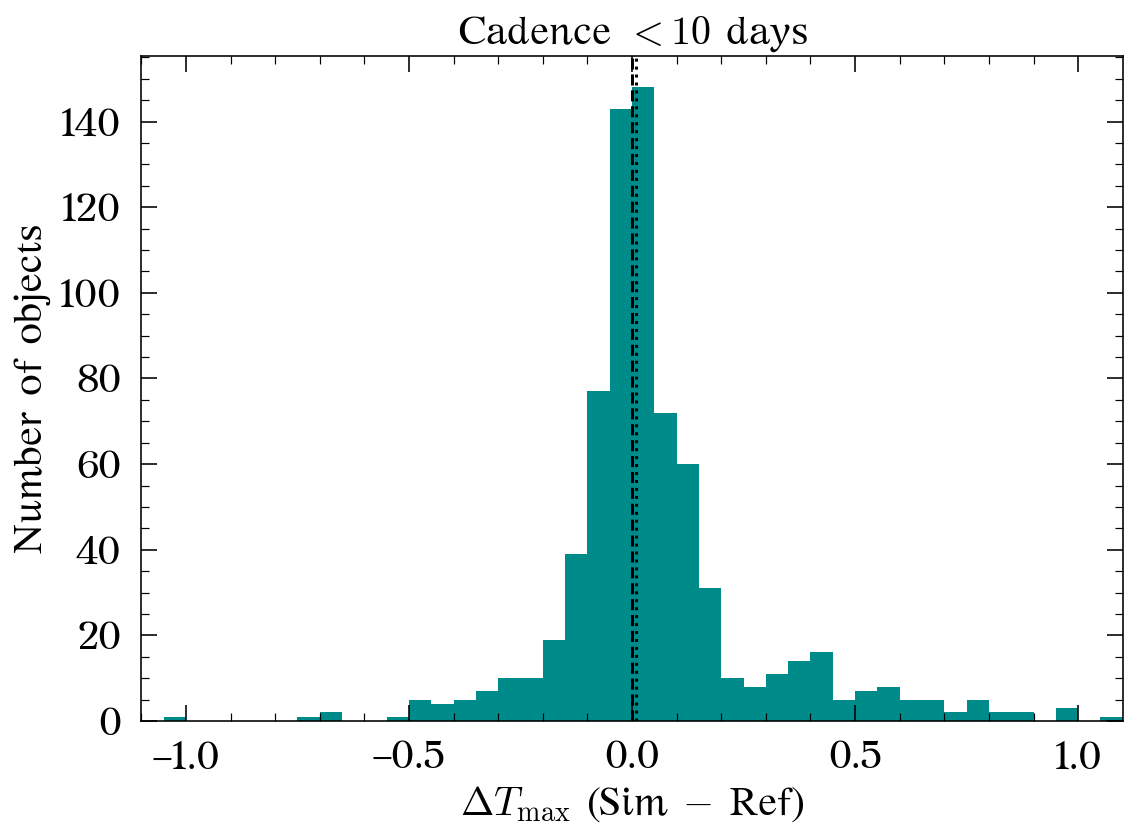

0.008176660375119453 0.514890961199027


In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-1.1, 1.15, 0.05)
ax.hist(res_df.Tmax_diff, bins, color='darkcyan')
ax.axvline(0, ls='--', c='k')
wmean = np.average(res_df.Tmax_diff.values,
                  weights=1/res_df.Tmax_err.values**2)
ax.axvline(wmean, ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.set_title('Cadence $< 10$ days', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(-1.1, 1.1)

fig.tight_layout()
plt.savefig('paper_plots/delta_Tmax_cadence.pdf')
plt.show()

print(wmean, res_df.Tmax_diff.std())

In [26]:
np.std(res_df.Tmax_diff.values)

0.5145457442904904

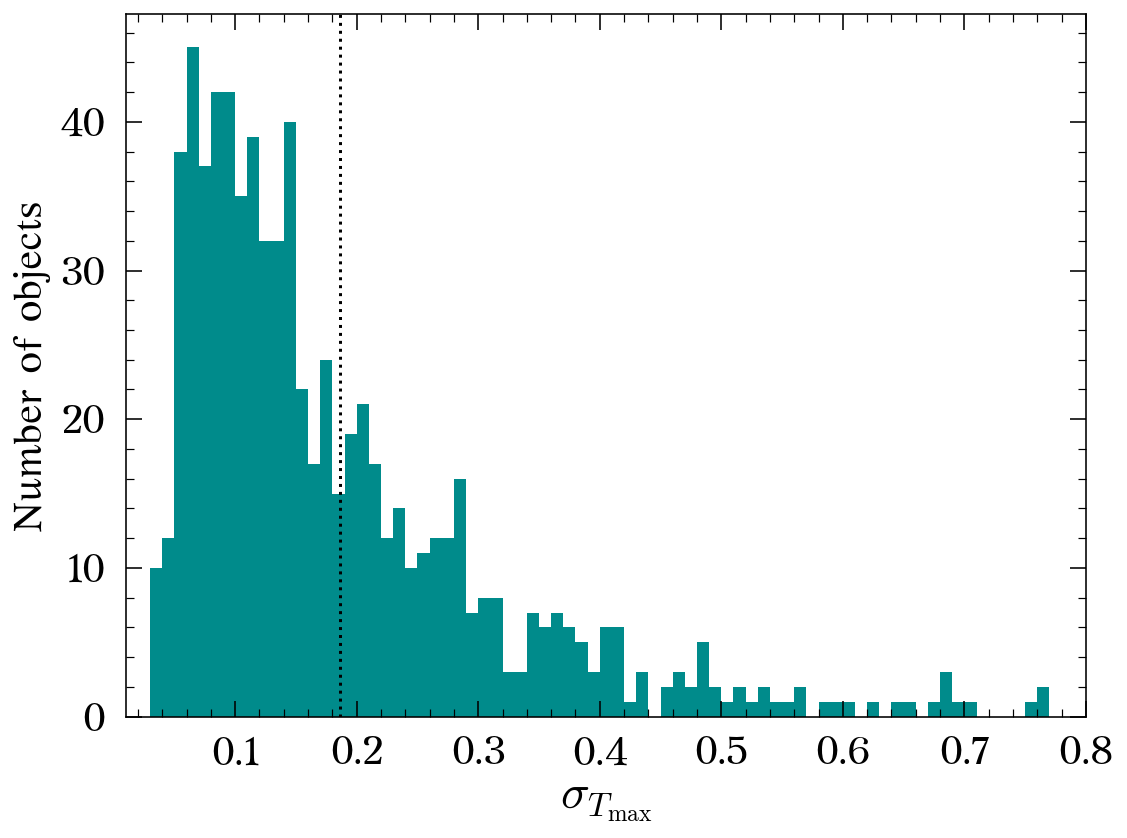

0.186121638918111


In [53]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(0, 0.9, 0.01)
ax.hist(res_df.Tmax_err, bins, color='darkcyan')
ax.axvline(res_df.Tmax_err.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{T_{\rm max}}$', fontsize=24)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.01, 0.8)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_cadence.pdf')
plt.show()
print(res_df.Tmax_err.mean())

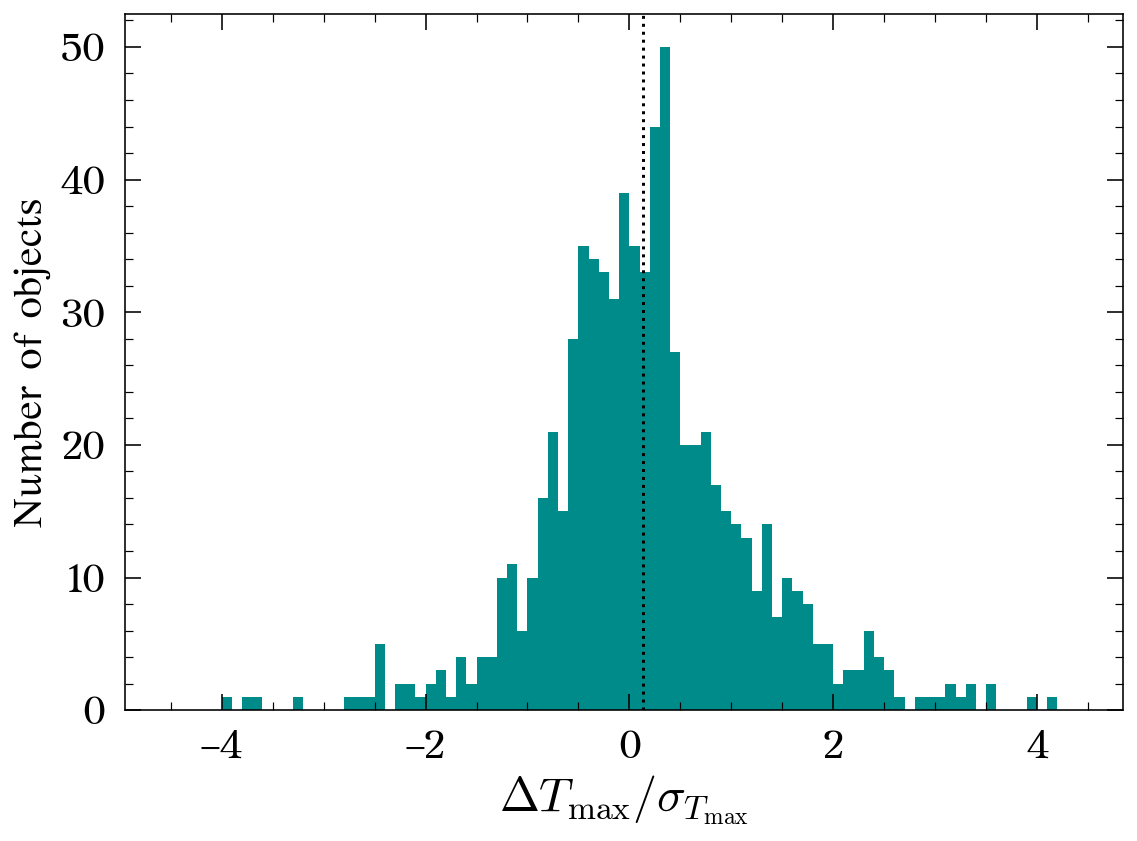

0.13042739723703844


In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-4.5, 4.5, 0.1)
ax.hist(res_df.Tmax_diff/res_df.Tmax_err, bins, color='darkcyan')
mean = np.mean(res_df.Tmax_diff/res_df.Tmax_err)
ax.axvline(mean, ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}/\sigma_{T_{\rm max}}$', fontsize=24)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(0.01, 0.8)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_cadence.pdf')
plt.show()
print(mean)

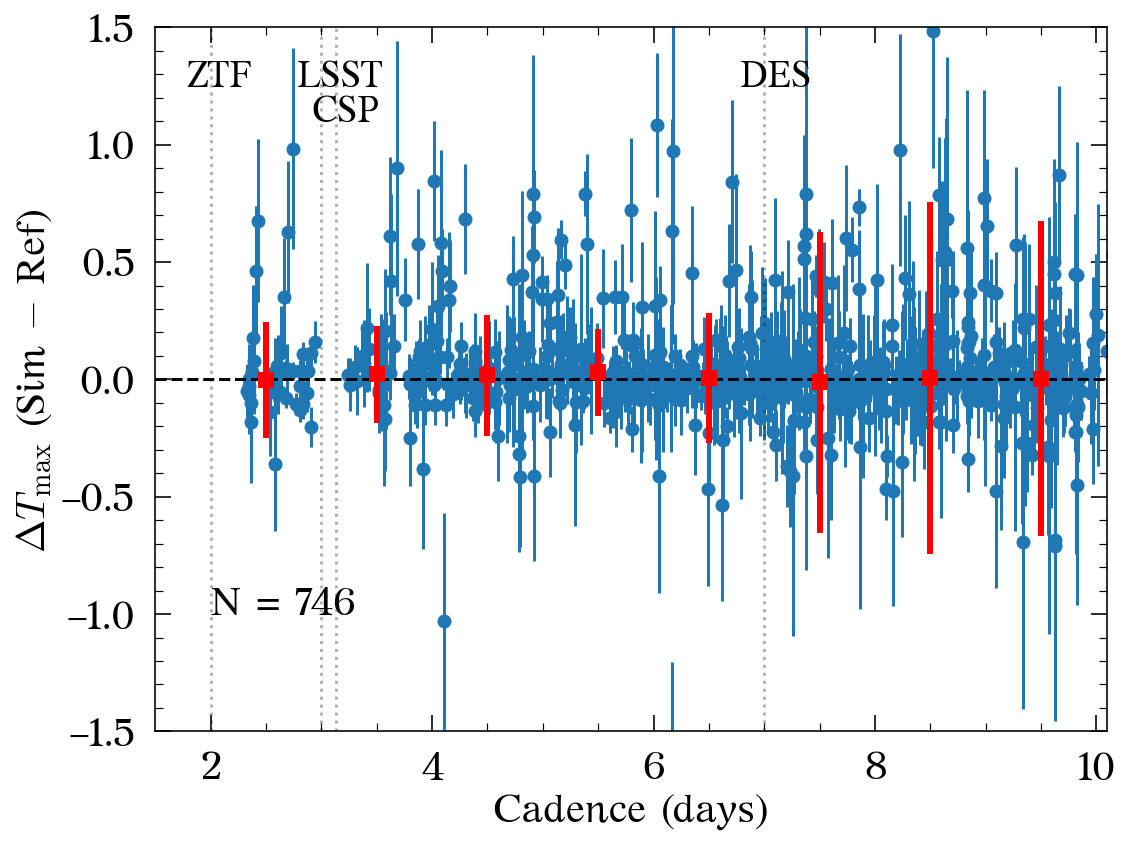

3.1314074109217844


In [9]:
# average CSP cadence
avg_cad = []
for sn_name in sn_names:
    sn_df = cad_stats_df[cad_stats_df.name==sn_name]
    sn_df = sn_df[sn_df.step==0]
    cad = sn_df.g.values[0]
    avg_cad.append(cad)
    
avg_cad = np.array(avg_cad).mean()

cadence_dict = {'CSP':avg_cad,
                'ZTF':2,
                'DES':7, 
                'LSST':3}
text_shift = []

bins = np.arange(0, 11, 1)
bins_results =  bin_values(bins, res_df.g.values/(1+sn_df.zspec.values), 
                           res_df.Tmax_diff.values,
                            res_df.Tmax_err.values)
wmean_bins, std_bins = bins_results


fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(res_df.g/(1+sn_df.zspec.values), res_df.Tmax_diff, 
            yerr=res_df.Tmax_err, fmt='o')

# bins
ax.errorbar(bins-0.5, wmean_bins, yerr=std_bins, 
            fmt='s', c='red', zorder=10, ms=7, elinewidth=3)

ax.axhline(0, ls='--', c='k', zorder=5)

for survey, cad in cadence_dict.items():
    if survey in ['ZTF', 'LSST', 'DES']:
        yoffset = 1.25
    else:
        yoffset = 1.1
    ax.axvline(cad, ls='dotted', c='k', alpha=0.3)
    ax.text(cad-0.22, yoffset, survey, fontsize=18)

ax.set_xlabel(r'Cadence (days)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(1.5, 10.1)
ax.set_ylim(-1.5, 1.5)
ax.text(2, -1, f'N = {len(res_df.g)}', fontsize=20)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_Tmax_vs_cadence.pdf')
plt.show()

print(avg_cad)

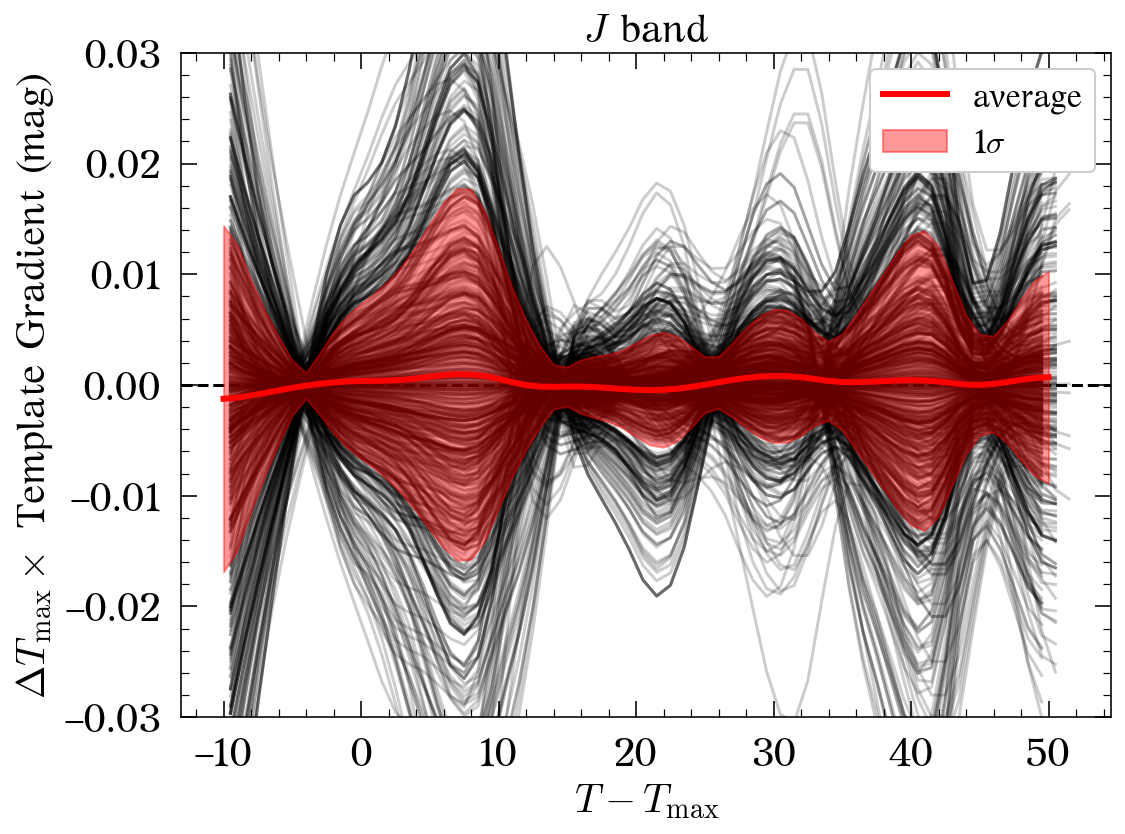

In [17]:
band = 'J'

avg_err = []
epochs = np.arange(-10, 51)

fig, ax = plt.subplots(figsize=(8, 6))
for err, time in zip(lc_snake[band]['err'], 
                     lc_snake[band]['time']):
    
    interp_err = np.interp(epochs, time, err)
    
    # remove weird outliers
    if np.all(np.abs(interp_err)<0.05):
        ax.plot(time, err, 'k', alpha=0.2)
        avg_err.append(interp_err)
    
std_err = np.std(avg_err, axis=0)
avg_err = np.average(avg_err, axis=0)
ax.plot(epochs, avg_err, 'r', label='average', lw=3, zorder=30)
ax.fill_between(epochs, avg_err+std_err, avg_err-std_err, 
                color='r', alpha=0.4, label='1$\sigma$', zorder=20)
ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$T - T_{\rm max}$', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max} \times$ Template Gradient (mag)', fontsize=20)
ax.set_title(f'${band}$ band', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.03, 0.03)
ax.legend(loc=1, fontsize=16, framealpha=1).set_zorder(10)
fig.tight_layout()
#plt.savefig(f'paper_plots/Tmax_gradient_cadence_{band}.pdf')
plt.show()

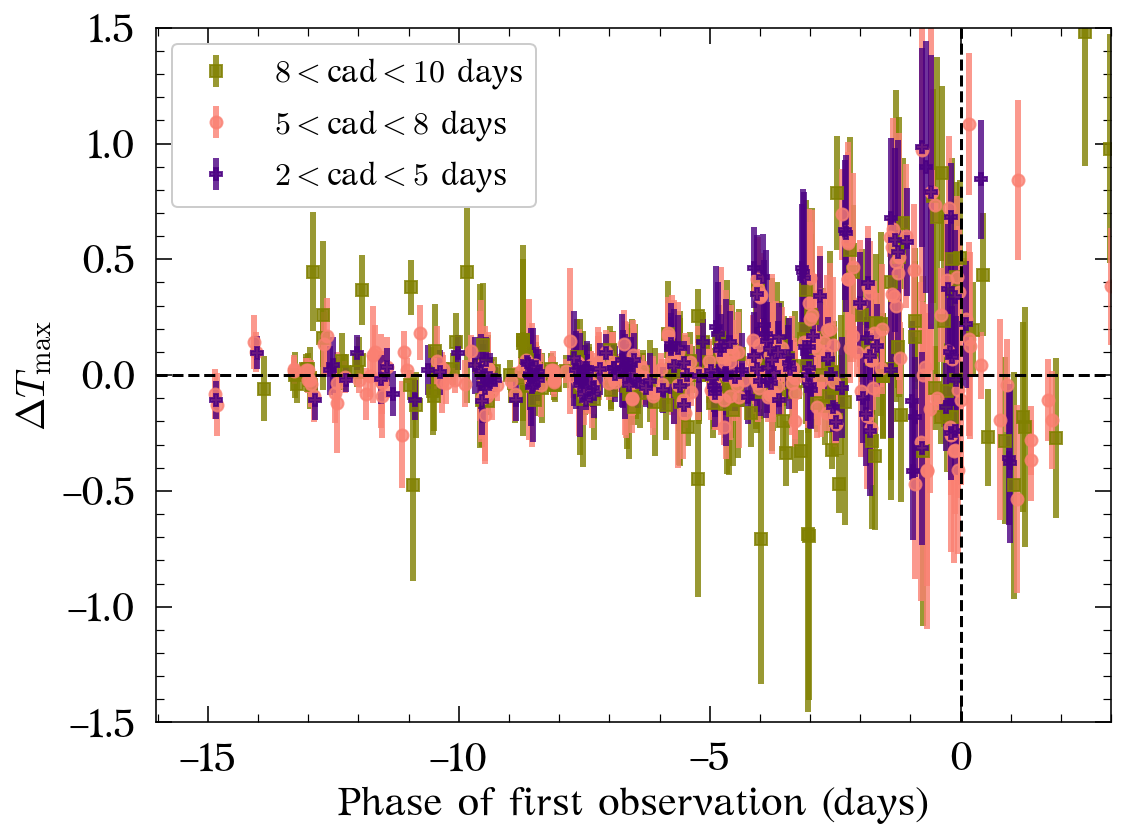

In [41]:
cadences = np.arange(2, 12, 3)[::-1]
cadences[0] = 10
colours = ['olive', 'salmon', 'indigo']
markers = ['s', 'o', 'P']

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(cadences)-1):
    mask = (res_df.g>cadences[i+1]) & (res_df.g<cadences[i])
    cad_df = res_df[mask]
    x = cad_df.first_phase.values
    y = cad_df.Tmax_diff.values
    yerr = cad_df.Tmax_err.values

    label = f'${cadences[i+1]}<$cad$<{cadences[i]}$ days'
    colour = colours[i]
    marker = markers[i]
    ax.errorbar(x, y, yerr=yerr, fmt=marker, lw=3, 
                label=label, alpha=0.8, c=colour)
    
ax.axhline(0, ls='--', c='k', zorder=10)
ax.axvline(0, ls='--', c='k', zorder=10)

ax.set_xlabel(r'Phase of first observation (days)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(None, 3)
ax.legend(loc=2, fontsize=16, framealpha=1).set_zorder(20)
fig.tight_layout()
plt.savefig(f'paper_plots/Tmax_running_cadence.pdf')
plt.show()

___
## Signal-to-Noise

In [6]:
bands = ['g', 'r']
multi = range(2, 7)

with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

snr_list = Pool(PROCESSES).map(pool_fit_snr, ([sn_file, multi, bands] for sn_file in sn_files))

/tmp/ipykernel_27090/20992180.py:217: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/sn.py:360: RuntimeWarning: invalid value encountered in log10
  temp1[i] = -2.5*log10(af) + self.data[band].filter.zp
/tmp/ipykernel_27090/20992180.py:217: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/sn.py:360: RuntimeWarning: invalid value encountered in log10
  temp1[i] = -2.5*log10(af) + self.data[band].filter.zp
/tmp/ipykernel_27090/20992180.py:217: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/sn.py:360: RuntimeWarning: invalid value encountered in log10
  temp1[i] = -2.5*log10(af) + self.data[band].filter.zp
/tmp/ipykernel_27090/20992180.py:217: Ru

In [7]:
snr_stats_df = pd.concat(snr_list, ignore_index=True)
snr_stats_df.to_csv('snr_stats.csv', index=False)

___
### Signal-to-Noise Analysis

In [48]:
snr_stats_df = pd.read_csv('snr_stats.csv')
sn_names = snr_stats_df.name.unique()

res_dict = {'Tmax_diff':[], 'Tmax_err':[], 'g':[], 'r':[]}
lc_snake = {band:{'err':[], 'time':[]} for band in ['J', 'H']}

g_mean_snr = []
for sn_name in sn_names:
    sn_df = snr_stats_df[snr_stats_df.name==sn_name]
    ref_df = sn_df.iloc[0]
    g_mean_snr.append(ref_df.g)
        
    sim_df = sn_df[1:]  # remove reference from this df
    sim_df = sim_df[sim_df.g>=0]
    Tmax_diff = sim_df.Tmax.values - ref_df.Tmax
    res_dict['Tmax_diff'] += list(Tmax_diff)
    res_dict['Tmax_err'] += list(sim_df.Tmax_err)
    res_dict['g'] += list(sim_df.g)
    res_dict['r'] += list(sim_df.r)
            
    lc_dict = extract_gradient(ref_df.st)
    for band in ['J', 'H']:
        lc = lc_dict[band]
        time = lc['time'][:-1]+0.5
        grad = lc['slope']
        for val in Tmax_diff:
            err = val * grad  # the offset we want per object
            lc_snake[band]['err'].append(err)
            lc_snake[band]['time'].append(time)
            
res_df = pd.DataFrame(res_dict)
# weird outliers, but just very few simulations
res_df = res_df[np.abs(res_df.Tmax_diff)<0.6]  # "huge" Tmax diff by looking at the distribution
res_df = res_df[res_df.Tmax_err>0.01]  # I don't trust these small uncertainties 
print(np.array(g_mean_snr).mean())

113.88138148922688


In [11]:
np.array(g_mean_snr).max()

187.34069444444444

In [49]:
step = 20
snrs = np.arange(0, 100+step, step)
print(f'Weighted mean +/- std of delta Tmax:')
for i in range(len(snrs)-1):
    snr_min = snrs[i]
    snr_max = snrs[i+1]
    mask = (snr_min<=res_df.g) & (res_df.g<=snr_max)
    snr_df = res_df[mask]

    label = f'{int(snr_min+step/2)}'
    wmean = np.average(snr_df.Tmax_diff.values, 
                       weights=1/snr_df.Tmax_err.values**2)
    std = np.std(snr_df.Tmax_diff.values)
    print(f'For S/N={label}: {wmean:.3f} +/- {std:.3f} days')

Weighted mean +/- std of delta Tmax:
For S/N=10: 0.030 +/- 0.181 days
For S/N=30: 0.026 +/- 0.120 days
For S/N=50: 0.020 +/- 0.084 days
For S/N=70: 0.006 +/- 0.055 days
For S/N=90: 0.009 +/- 0.039 days


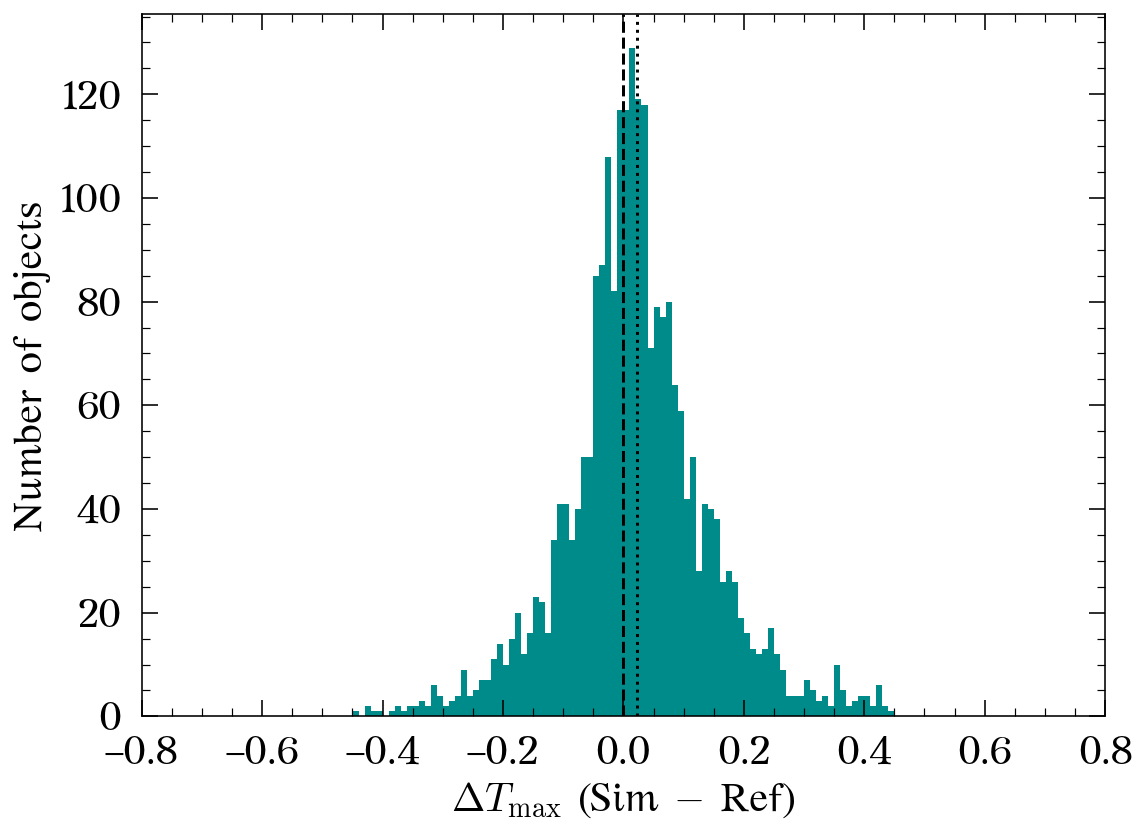

0.021829387976935455 0.12899475363777013


In [86]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-0.45, 0.46, 0.01)
ax.hist(res_df.Tmax_diff, bins, color='darkcyan')
ax.axvline(0, ls='--', c='k')
wmean = np.average(res_df.Tmax_diff.values, 
                   weights=1/res_df.Tmax_err.values**2)
ax.axvline(wmean, ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(-0.8, 0.8)

fig.tight_layout()
plt.savefig('paper_plots/delta_Tmax_snr.pdf')
plt.show()

print(wmean, res_df.Tmax_diff.std())

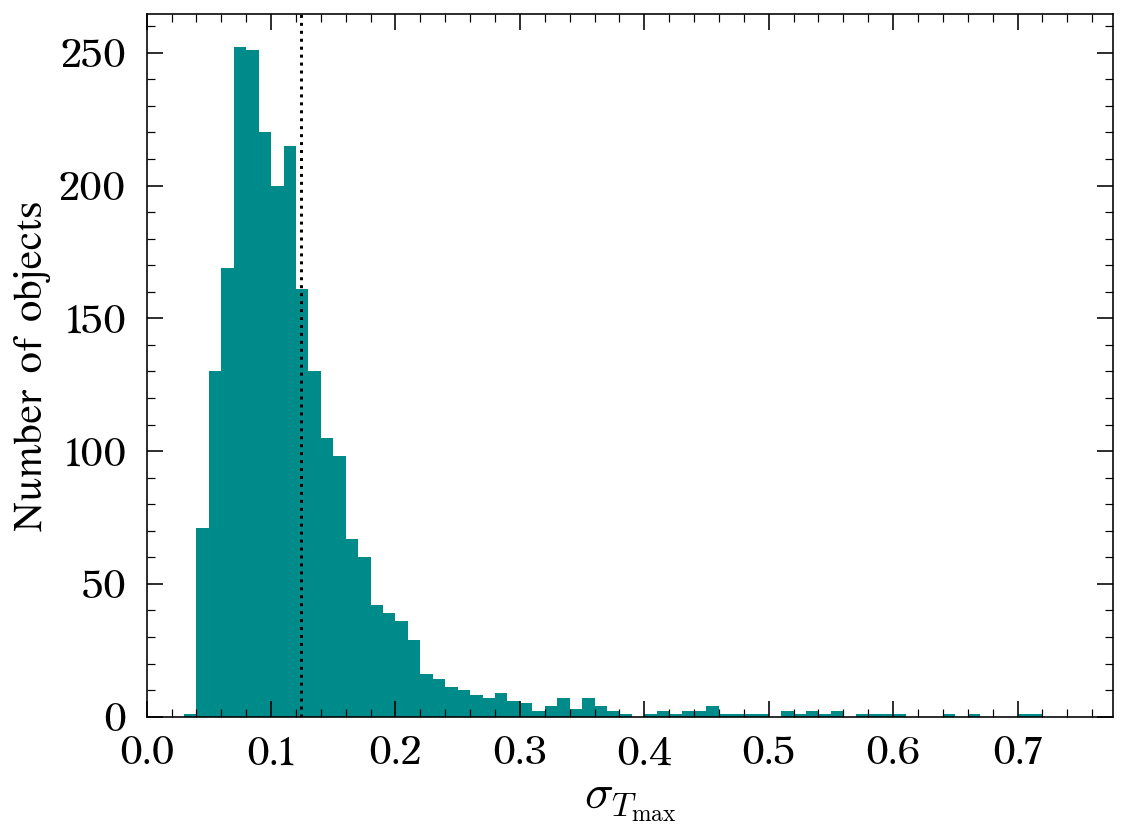

0.12322961440507223


In [80]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(0, 0.75, 0.01)
ax.hist(res_df.Tmax_err, bins, color='darkcyan')
ax.axvline(res_df.Tmax_err.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{T_{\rm max}}$', fontsize=24)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0, None)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_snr.pdf')
plt.show()

print(df.Tmax_err.mean())

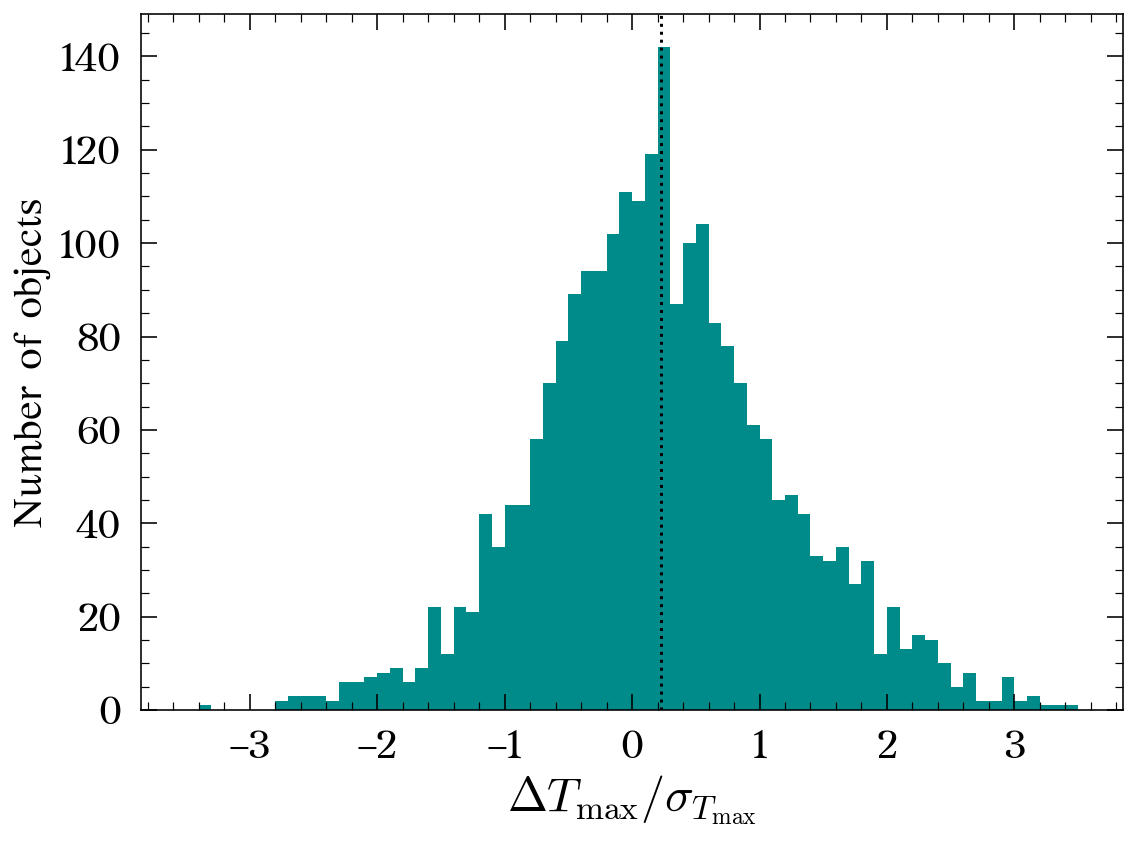

0.2273138305697315


In [46]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-3.5, 3.6, 0.1)
ax.hist(res_df.Tmax_diff/res_df.Tmax_err, bins, color='darkcyan')
mean = np.mean(res_df.Tmax_diff/res_df.Tmax_err)
ax.axvline(mean, ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}/\sigma_{T_{\rm max}}$', fontsize=24)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(0, None)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_snr.pdf')
plt.show()

print(mean)

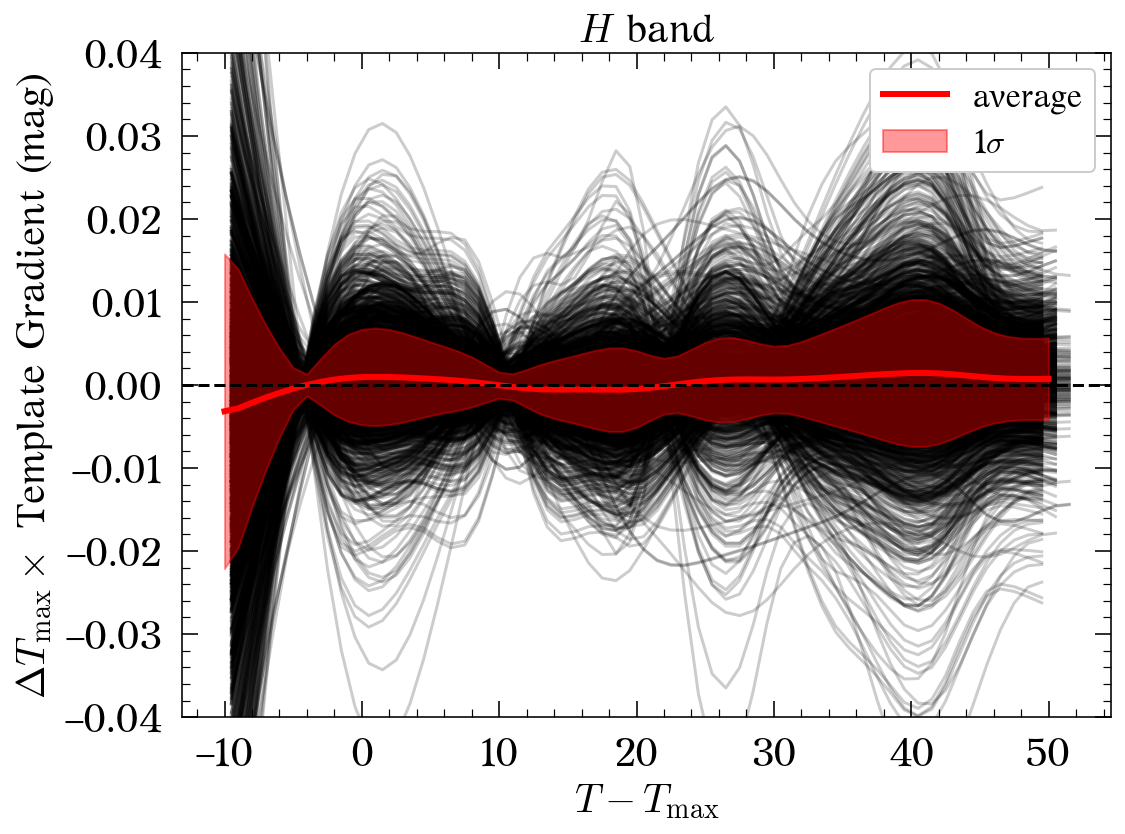

In [81]:
band = 'H'

avg_err = []
epochs = np.arange(-10, 51)

fig, ax = plt.subplots(figsize=(8, 6))
for err, time in zip(lc_snake[band]['err'], 
                     lc_snake[band]['time']):
    
    interp_err = np.interp(epochs, time, err)
    
    # remove weird outliers
    if np.all(np.abs(interp_err)<0.1):
        ax.plot(time, err, 'k', alpha=0.2)
        avg_err.append(interp_err)
    
std_err = np.std(avg_err, axis=0)
avg_err = np.average(avg_err, axis=0)
ax.plot(epochs, avg_err, 'r', label='average', lw=3, zorder=30)
ax.fill_between(epochs, avg_err+std_err, avg_err-std_err, 
                color='r', alpha=0.4, zorder=20, label='1$\sigma$')
ax.axhline(0, ls='--', c='k', zorder=50)

ax.set_xlabel(r'$T - T_{\rm max}$', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max} \times$ Template Gradient (mag)', fontsize=20)
ax.set_title(f'${band}$ band', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.04, 0.04)
ax.legend(loc=1, fontsize=16, framealpha=1).set_zorder(20)
fig.tight_layout()
plt.savefig(f'paper_plots/Tmax_gradient_snr_{band}.pdf')
plt.show()

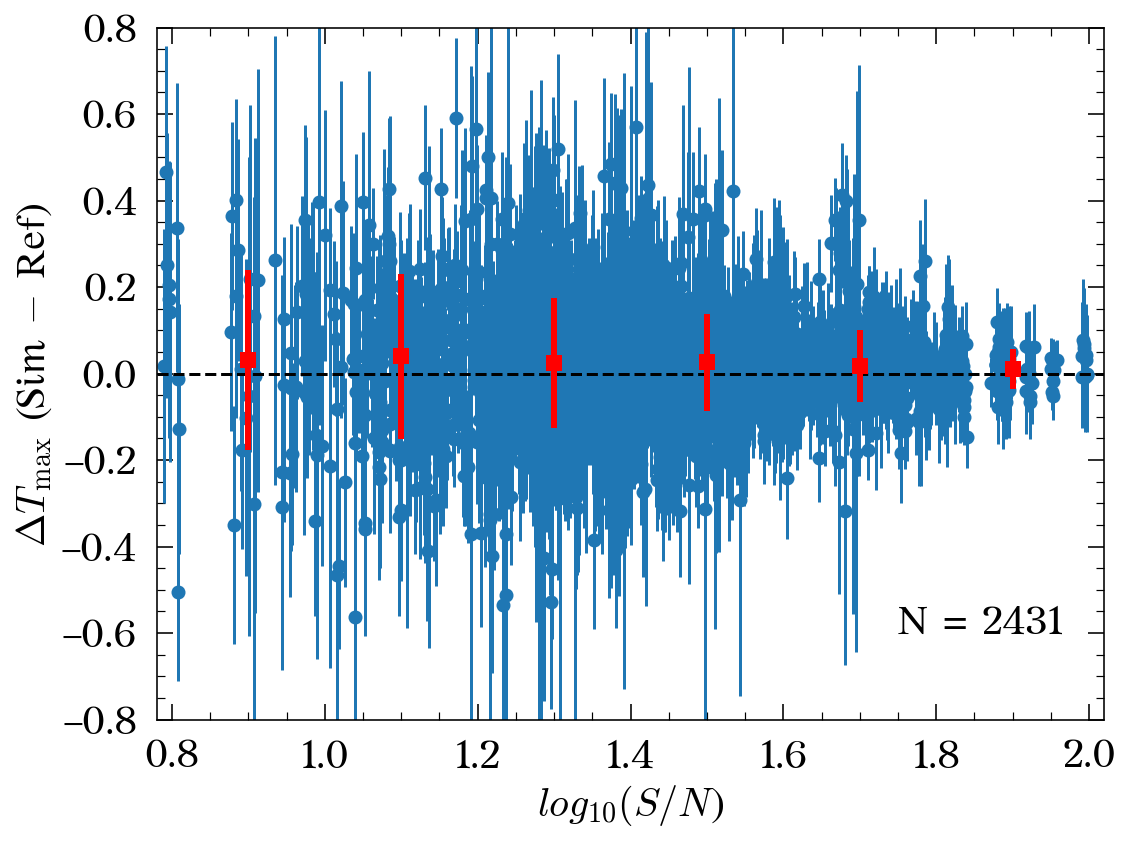

In [50]:
step = 0.2
bins = np.arange(0.8, 2.8+step, step)
bins_results =  bin_values(bins, np.log10(res_df.g.values), 
                           res_df.Tmax_diff.values,
                            res_df.Tmax_err.values)
wmean_bins, std_bins = bins_results


fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(np.log10(res_df.g), res_df.Tmax_diff, 
            yerr=res_df.Tmax_err, fmt='o')

# bins
ax.errorbar(bins-step/2, wmean_bins, yerr=std_bins, 
            fmt='s', c='red', zorder=10, ms=7, elinewidth=3)

ax.axhline(0, ls='--', c='k', zorder=5)

ax.set_xlabel(r'$log_{10}(S/N$)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.8, 0.8)
ax.set_xlim(0.78, 2.02)
ax.text(1.75, -0.6, f'N = {len(res_df.g)}', fontsize=20)
#ax.set_xlim(None, None)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_Tmax_vs_snr.pdf')
plt.show()

___

## S/N on NIR

Get the closest NIR epoch to Tmax and degrade the S/N to see how that affects Jmax. Use grJ with all data and grJ with one J epoch as a references.

In [7]:
bands = None
multi = range(2, 11)

with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

snr_list = Pool(PROCESSES).map(pool_fit_NIR_snr, ([sn_file, multi, bands] for sn_file in sn_files))

/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 6 failed for SN2005hc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 6 failed for SN2005hc: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!
Multiplier 7 failed for SN2006hx: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!
Multiplier 6 failed for SN2005hc: All weights for filter J are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 6 failed for SN2005hc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 7 failed for SN2005hc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2005hc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 8 failed for SN2005hc: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2005hc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2005hc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 9 failed for SN2005hc: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!
Multiplier 10 failed for SN2005hc: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 10 failed for SN2005hc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 10 failed for SN2005hc: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 10 failed for SN2005hc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2006kf: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2005M: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 2 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 2 failed for ASAS14lp: index 1 is out of bounds for axis 1 with size 1!
Multiplier 2 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 2 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 2 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Mul

/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 7 failed for SN2008hj: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2008hj: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 4 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2008hj: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 5 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 5 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 5 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 5 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/model.py:310: RuntimeWarning: overflow encountered in power
  f = power(10, -0.4*(mod - self.parent.data[band].filter.zp))
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/model.py:322: RuntimeWarning: invalid value encountered in multiply
  resids_list.append((f - self.parent.data[band].flux)*W)
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/mangle_spectrum.py:608: RuntimeWarning: overflow encountered in power
  resps[-1].append(num.power(10, -0.4*(mags[i][j] - fset[b].zp)))
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/mangle_spectrum.py:613: RuntimeWarning: invalid value encountered in true_divide
  resps[i,:] = resps[i,:]/resps[i,nid]
/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2007on: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 5 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 5 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 5 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2008hj: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 6 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 6 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/kcorr.py:803: RuntimeWarning: invalid value encountered in log10
  A_obs = -2.5*num.log10(resp_red/resp)
/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2008hj: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 6 failed for ASAS14lp: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!
Multiplier 6 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 10 failed for SN2008hj: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 10 failed for SN2008hj: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 10 failed for SN2008hj: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 7 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 7 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 8 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 8 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 8 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two

/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/model.py:310: RuntimeWarning: overflow encountered in power
  f = power(10, -0.4*(mod - self.parent.data[band].filter.zp))
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/model.py:322: RuntimeWarning: invalid value encountered in multiply
  resids_list.append((f - self.parent.data[band].flux)*W)
/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/snpy/model.py:313: RuntimeWarning: overflow encountered in power
  cov_f = power(f*err/1.0857,2)


Multiplier 9 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 10 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 10 failed for ASAS14lp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2008ar: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 9 failed for SN2009I: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 4 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 6 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2013M: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 7 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 7 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 7 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 8 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 8 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2013M: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 10 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 10 failed for SN2007bd: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 10 failed for SN2013M: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2011iv: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2011iv: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2011iv: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp
/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 10 failed for SN2011iv: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 4 failed for SN2008gp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 6 failed for SN2008gp: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!
Multiplier 10 failed for SN2008bf: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 7 failed for SN2008gp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 8 failed for SN2008gp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!
Multiplier 8 failed for SN2008gp: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!
Multiplier 8 failed for SN2008gp: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!
Multiplier 9 failed for SN2008gp: All weights for filter H are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2008gp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 10 failed for SN2008gp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 10 failed for SN2008gp: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


/tmp/ipykernel_16205/4217499771.py:125: RuntimeWarning: invalid value encountered in log10
  new_mag = -2.5*np.log10(new_flux) + zp


Multiplier 9 failed for SN2008bc: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.!


In [8]:
nir_snr_stats_df = pd.concat(snr_list, ignore_index=True)
nir_snr_stats_df.to_csv('nir_snr_stats.csv', index=False)

___
### S/N on NIR Analysis

In [47]:
nir_snr_stats_df = pd.read_csv('nir_snr_stats.csv')
# AllBands (ab)
ab_df = pd.read_csv('reference_results_max_model.csv')

sn_names = nir_snr_stats_df.name.unique()

res_dict = {'Jmax_diff':[], 'Jmax_err':[], 
            'Hmax_diff':[], 'Hmax_err':[], 
            'J':[], 'H':[]}

ref_mean_J_cad = []
ref_mean_H_cad = []
for sn_name in sn_names:
    sn_df = nir_snr_stats_df[nir_snr_stats_df.name==sn_name]
    ref_df0 = sn_df.iloc[0]  # Ref using all epochs in J and H
    ref_df1 = sn_df.iloc[1]  # Ref using single epoch in J and H
    sn_ab_df = ab_df[ab_df.name==sn_name]  # Ref using all bands
        
    sim_df = sn_df[2:]  # remove references from this df
    #Jmax_diff = sim_df.Jmax.values - ref_df0.Jmax
    #Jmax_diff = sim_df.Jmax.values - ref_df1.Jmax
    Jmax_diff = sim_df.Jmax.values - sn_ab_df.Jmax_AllBands.values[0]
    
    #Hmax_diff = sim_df.Hmax.values - ref_df0.Hmax
    #Hmax_diff = sim_df.Hmax.values - ref_df1.Hmax
    Hmax_diff = sim_df.Hmax.values - sn_ab_df.Hmax_AllBands.values[0]
    
    res_dict['Jmax_diff'] += list(Jmax_diff)
    res_dict['Jmax_err'] += list(sim_df.Jmax_err)
    res_dict['Hmax_diff'] += list(Hmax_diff)
    res_dict['Hmax_err'] += list(sim_df.Hmax_err)
    res_dict['J'] += list(sim_df.J)
    res_dict['H'] += list(sim_df.H)
    
    ref_mean_J_cad.append(ref_df0.J)
    ref_mean_H_cad.append(ref_df0.H)
            
res_df = pd.DataFrame(res_dict)

ref_mean_J_cad = np.array(ref_mean_J_cad)
ref_mean_H_cad = np.array(ref_mean_H_cad)
print(ref_mean_J_cad.mean(), ref_mean_H_cad.mean())

54.17344635426565 38.65800216280707


In [7]:
band = 'H'
step = 10
snrs = np.arange(0, 80+step, step)
print(f'Weighted mean +/- std of delta {band}max:')
for i in range(len(snrs)-1):
    snr_min = snrs[i]
    snr_max = snrs[i+1]
    mask = (snr_min<=res_df.J) & (res_df.J<=snr_max)
    snr_df = res_df[mask]

    label = f'{snr_min+step/2}'
    wmean = np.average(snr_df[f'{band}max_diff'].values, 
                       weights=1/snr_df[f'{band}max_err'].values**2)
    std = np.std(snr_df[f'{band}max_diff'].values)
    print(f'For S/N={label}: {wmean:.3f} +/- {std:.3f} days')

Weighted mean +/- std of delta Hmax:
For S/N=5.0: -0.060 +/- 0.530 days
For S/N=15.0: 0.008 +/- 0.214 days
For S/N=25.0: 0.014 +/- 0.129 days
For S/N=35.0: 0.005 +/- 0.097 days
For S/N=45.0: 0.033 +/- 0.090 days
For S/N=55.0: -0.001 +/- 0.051 days
For S/N=65.0: 0.035 +/- 0.062 days
For S/N=75.0: 0.035 +/- 0.039 days


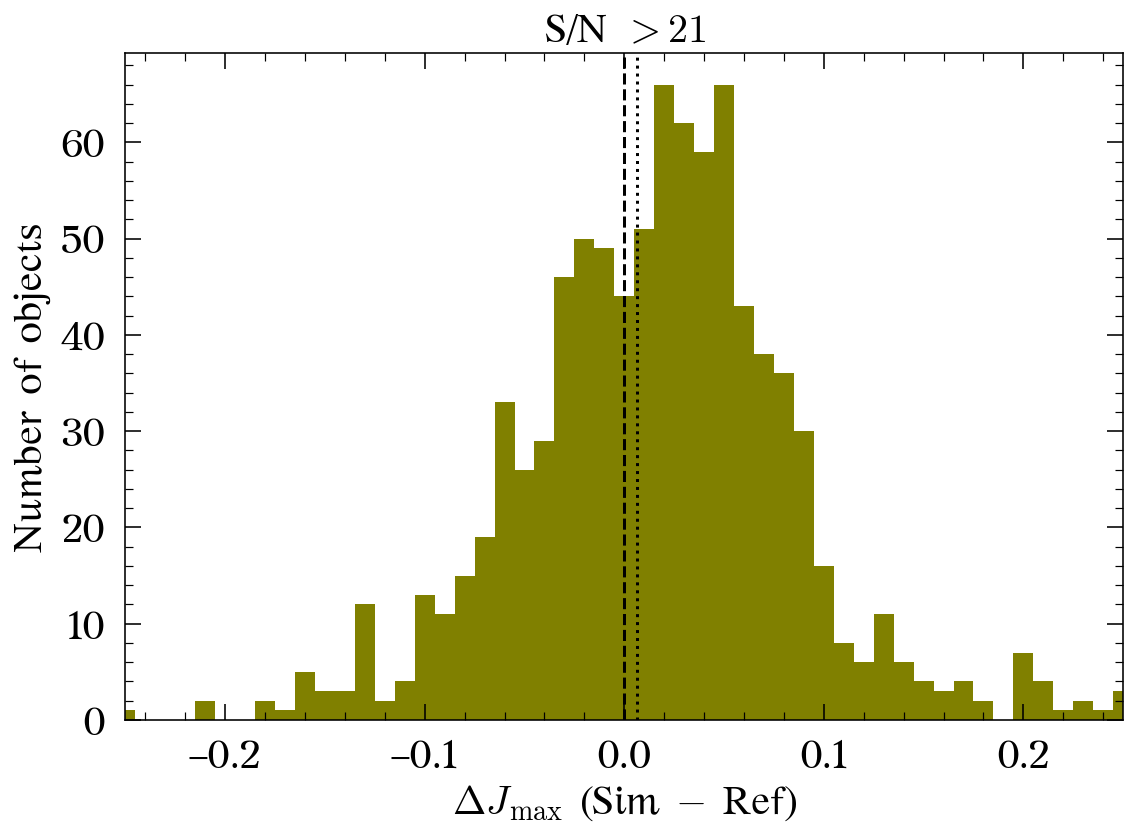

0.006147105744570795 0.06982388291544


In [22]:
band = 'J'
snr_threshold = 21
snr_mask = res_df[band]>snr_threshold
df = res_df[snr_mask]

fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-0.505, 0.5, 0.01)
ax.hist(df[f'{band}max_diff'], bins, color='olive')

ax.axvline(0, ls='--', c='k')
wmean = np.average(df[f'{band}max_diff'], 
                    weights=1/df[f'{band}max_err']**2)
ax.axvline(wmean, ls='dotted', c='k')

ax.set_xlabel(f'$\Delta {band}$'+r'$_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.set_title(f'S/N $> {snr_threshold}$', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(-0.25, 0.25)
#ax.legend(fontsize=14)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_{band}max_nir_snr.pdf')
plt.show()

print(wmean, df[f'{band}max_diff'].std())

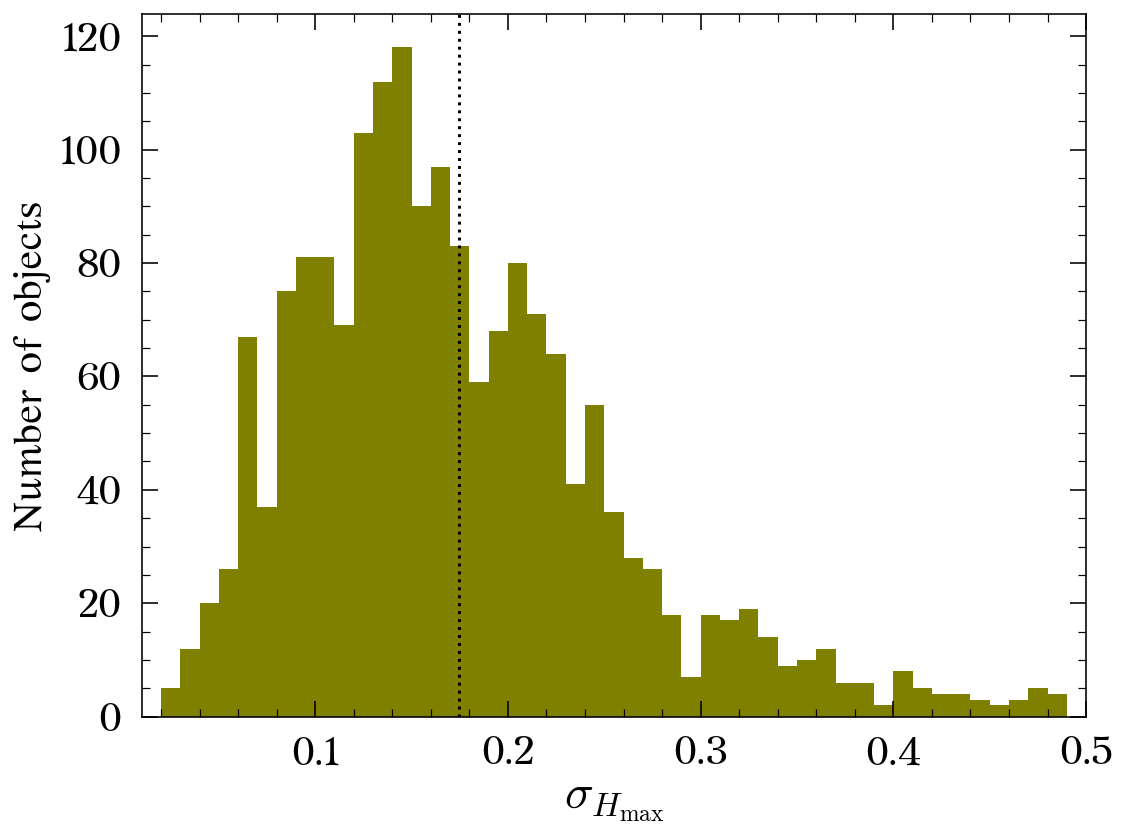

0.17464374389080972


In [131]:
fig, ax = plt.subplots(figsize=(8, 6))

if band=='H':
    bins = np.arange(0, 0.5, 0.01)
    ax.set_xlim(0.01, 0.5)
else:
    bins = np.arange(0, 0.5, 0.01)
    ax.set_xlim(0.01, 0.5)
    
ax.hist(df[f'{band}max_err'], bins, color='olive')
ax.axvline(df[f'{band}max_err'].mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{%s_{\rm max}}$'%band, fontsize=24)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)

fig.tight_layout()
plt.savefig(f'paper_plots/sigma_{band}max_nir_snr.pdf')
plt.show()
print(df[f'{band}max_err'].mean())

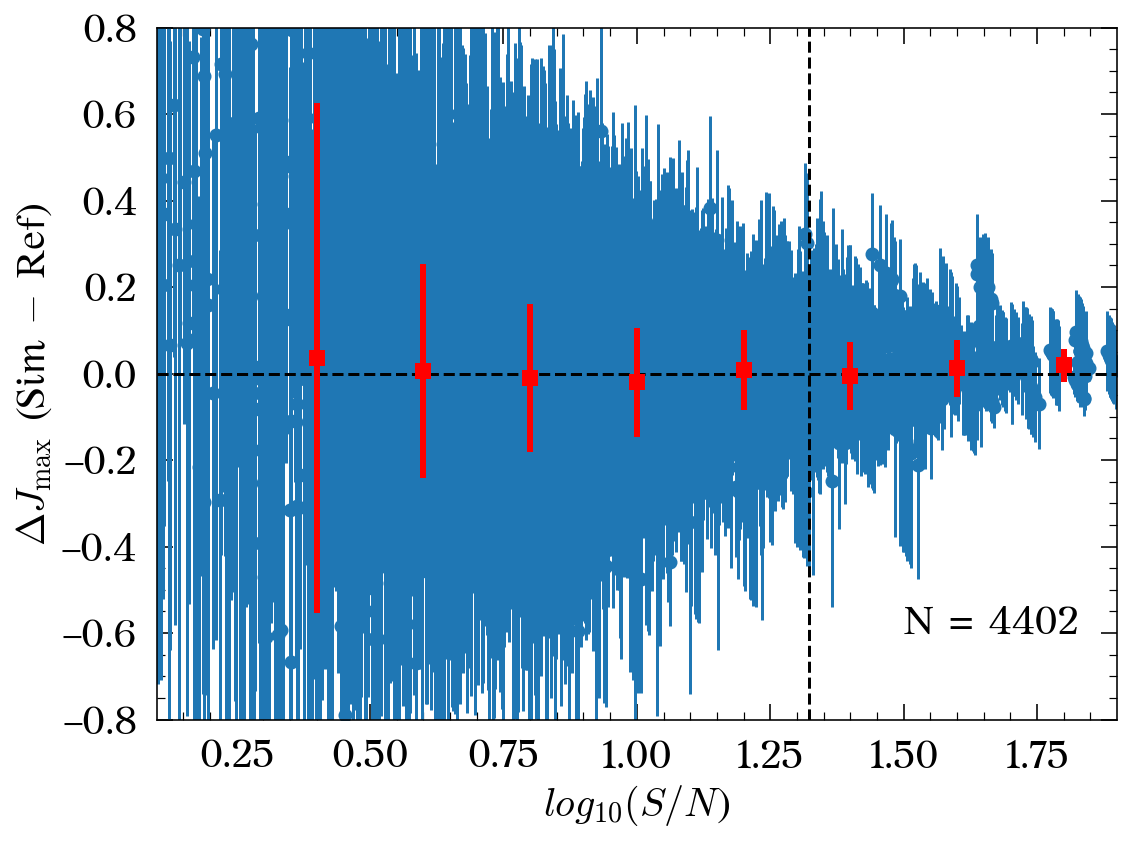

In [23]:
step = 0.2
bins = np.arange(0.5, 2.9+step, step)
bins_results =  bin_values(bins, np.log10(res_df[band].values), 
                           res_df[f'{band}max_diff'].values,
                            res_df[f'{band}max_err'].values)
wmean_bins, std_bins = bins_results


fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(np.log10(res_df[band]), res_df[f'{band}max_diff'], 
            yerr=res_df[f'{band}max_err'], fmt='o')

# bins
ax.errorbar(bins-step/2, wmean_bins, yerr=std_bins, 
            fmt='s', c='red', zorder=10, ms=7, elinewidth=3)

ax.axhline(0, ls='--', c='k', zorder=5)
ax.axvline(np.log10(snr_threshold), ls='--', c='k', zorder=5)

ax.set_xlabel(r'$log_{10}(S/N$)', fontsize=20)
ax.set_ylabel(r'$\Delta %s_{\rm max}$ (Sim $-$ Ref)'%band, fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.8, 0.8)
#ax.set_xlim(0.1, 2.05)
ax.set_xlim(0.1, 1.9)
#ax.set_xlim(None, None)
ax.text(1.5, -0.6, f'N = {len(res_df[band])}', fontsize=20)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_{band}max_vs_snr.pdf')
plt.show()

In [252]:
df = pd.read_csv('/home/tomas/Downloads/2021fof-ztf.csv', skiprows=14)
print('filt \t S/N \t obs. cadence')
for filt in df.photfilter.unique():
    filt_df = df[df.photfilter==filt]
    mag = 18.15
    mag_err = 0.052
    zp = 27.5
    flux = 10**( -0.4*(filt_df.mag.values-zp) )
    flux_err =  np.abs( flux*0.4*np.log(10)*filt_df.mag_err.values )
    snr = np.mean(flux/flux_err)
    print(filt, snr, np.mean(np.diff(filt_df.time)))

filt 	 S/N 	 obs. cadence
gp 11.940489006445976 3.5516689799912275
rp 14.083415141546096 3.142737911100051


In [241]:
# pick high-z SNe
z_list = []
for sn_file in glob.glob('csp_data/*'):
     with open(sn_file, 'r') as data_file:
            sn_info = data_file.readline().split()  # header
            z = float(sn_info[1])
            z_list.append(z)
            
z_array = np.array(z_list)

mask = z_array > 0.08
highz_sne = np.array(glob.glob('csp_data/*'))[mask]

#---------------
zp_dict = {'J':13.836, 'H':13.510}
zp = zp_dict[band]
names = ['mjd', 'mag', 'mag_err']

print('SN \t z \t S/N')
avg_snr = []
for k, sn_file in enumerate(highz_sne):
    skiprows = None
    nrows = None
    with open(sn_file, 'r') as data_file:
        for i, line in enumerate(data_file.readlines()):
            if band in line:
                skiprows = i
            if skiprows is not None:
                if 'filter' in line.split() and band not in line:
                    nrows = i - skiprows
                    break
       
    if nrows is None:
        nrows = 100
        
    if skiprows is None:
        continue
    
    sn_df = pd.read_csv(sn_file, names=names, skiprows=skiprows+1, 
                        nrows=nrows-1, delim_whitespace=True)
    
    flux = 10**( -0.4*(sn_df.mag.values-zp) )
    flux_err =  np.abs( flux*0.4*np.log(10)*sn_df.mag_err.values )
    snr = flux/flux_err
    print(sn_file, z_array[mask][k], snr)
    avg_snr.append(snr.mean())
    
avg_snr = np.array(avg_snr)
print(avg_snr.mean())

SN 	 z 	 S/N
csp_data/LSQ13pf_snpy.txt 0.086 [11.42880216]
csp_data/LSQ12bld_snpy.txt 0.0834 [36.19120683 20.10622601 16.20501798]
csp_data/CSP13aad_snpy.txt 0.0868 [ 7.98335445 11.67458285 10.6444726 ]
csp_data/LSQ14age_snpy.txt 0.0805 [16.9646282  16.20501798]
csp_data/LSQ14gfn_snpy.txt 0.1216 [11.67458285]
csp_data/LSQ14gov_snpy.txt 0.0895 [29.34422175 21.7147241 ]
csp_data/LSQ12aor_snpy.txt 0.0933 [16.9646282  18.71958974 10.05311301]
csp_data/LSQ12gln_snpy.txt 0.102 [32.90109711 24.67582284 17.23390801 18.71958974 14.8730987 ]
csp_data/CSP12N_snpy.txt 0.0971 [29.34422175 15.96670889 13.08115909]
csp_data/LSQ14bjj_snpy.txt 0.0811 [38.77629303 40.21245203 26.48137085 27.14340512]
csp_data/LSQ12cdl_snpy.txt 0.1079 [14.28600269 12.1992832  15.51051721 12.47972649]
csp_data/LSQ13dcy_snpy.txt 0.0801 [41.7590848  35.02374854]
csp_data/LSQ14auy_snpy.txt 0.0824 [45.23900853 31.02103442 36.19120683]
21.4249159493193


--------------------------------------------------------------------------------
SN  SN2005M
z = 0.0220          zcmb = 0.0230          ra=144.38480         dec= 23.20070 
Data in the following bands: g,  u,  V,  r,  i,  B,  J,  H,  K,  Y,  
Fit results (if any):
   st = 1.209  +/-  0.002  +/- 0.030 (sys)
   Tmax = 53405.745  +/-  0.019  +/- 0.340 (sys)
   gmax = 15.860  +/-  0.002  +/- 0.014 (sys)
   umax = 16.225  +/-  0.004  +/- 0.030 (sys)
   Vmax = 15.908  +/-  0.002  +/- 0.019 (sys)
   rmax = 16.005  +/-  0.002  +/- 0.022 (sys)
   imax = 16.530  +/-  0.003  +/- 0.022 (sys)
   Bmax = 15.939  +/-  0.002  +/- 0.012 (sys)
   Jmax = 16.682  +/-  0.140  +/- 0.044 (sys)
   Hmax = 16.684  +/-  0.016  +/- 0.055 (sys)
   Kmax = 16.551  +/-  0.046
   Ymax = 16.669  +/-  0.014  +/- 0.050 (sys)
None


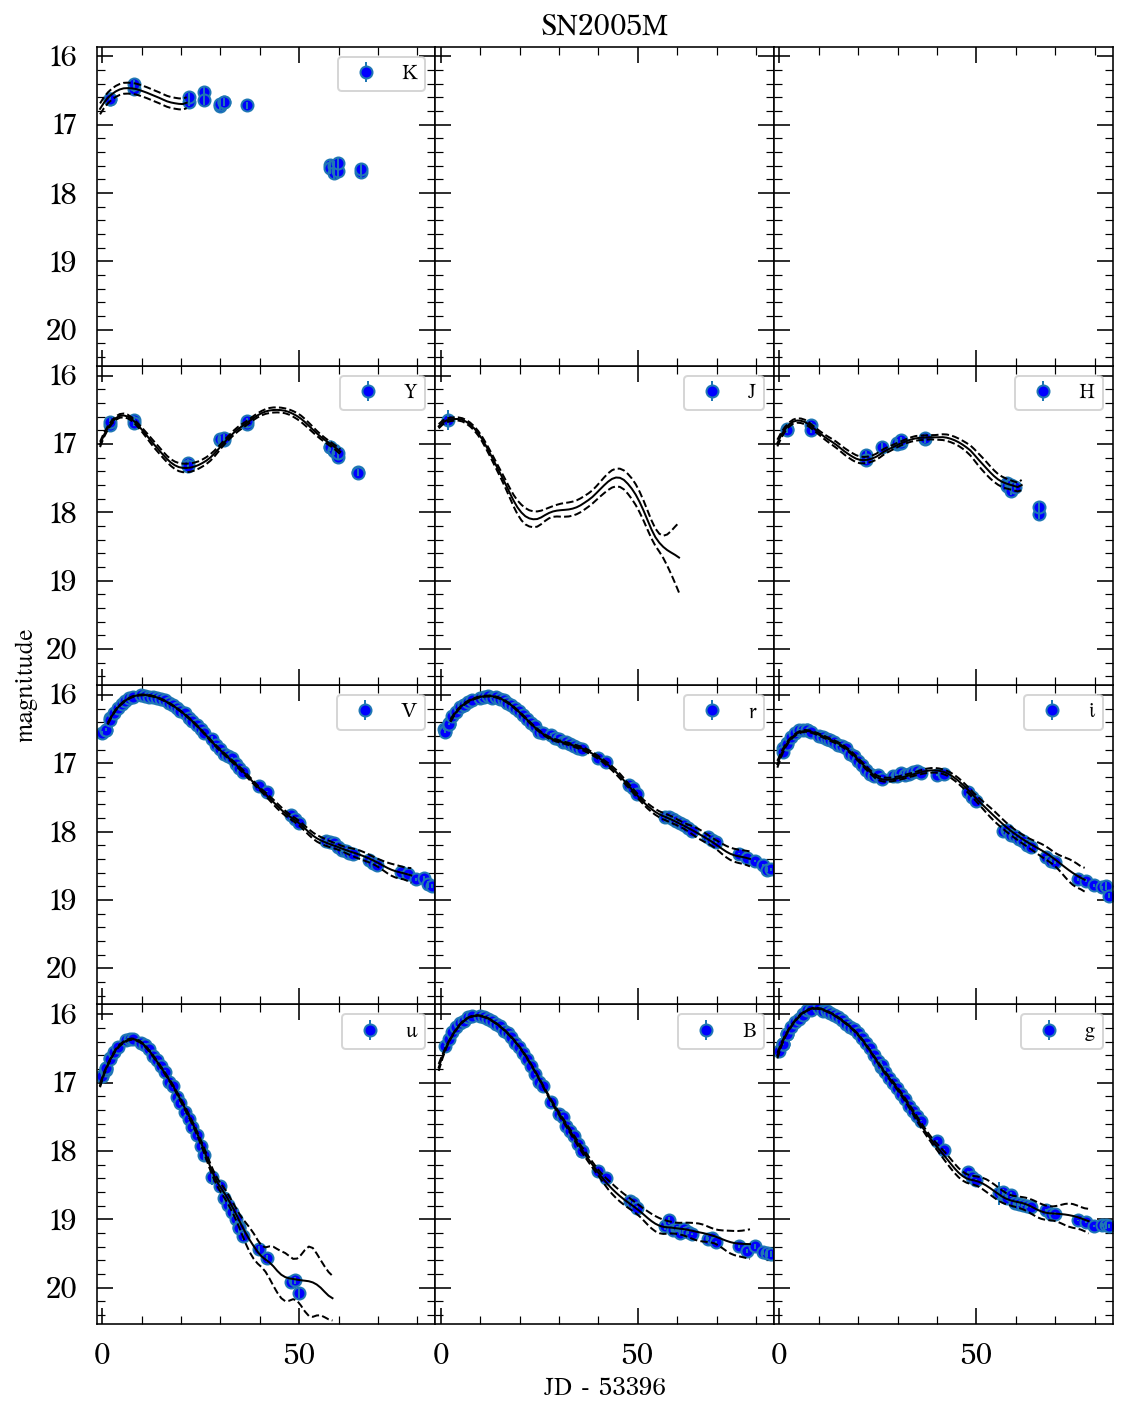

In [68]:
sn = snpy.import_lc('csp_data/SN2005M_snpy.txt')
sn.choose_model(SNOOPY_MODEL)

mult = 3
band = 'J'
sn.data[band].e_flux = mult*sn.data[band].e_flux
sn.data[band]._eflux = mult*sn.data[band]._eflux

zp = sn.data[band].mag + 2.5*np.log10(sn.data[band].flux)
# randomise observations within uncertainties
new_flux = np.random.normal(sn.data[band].flux, 
                            sn.data[band].e_flux)
sn.data[band].flux = new_flux

# update magnitudes and mag errors
new_mag = -2.5*np.log10(new_flux) + zp
new_mag_err = np.abs( 2.5*sn.data[band].e_flux/(new_flux*np.log(10)) )
sn.data[band].mag = new_mag
sn.data[band].magnitude = new_mag
sn.data[band].e_mag = new_mag_err

sn.fit()
print(sn.summary())